In [1]:
import networkx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from argparse import ArgumentParser
import scipy.spatial
import torch
import torch_geometric as pyg
import os
from torch_geometric.utils.convert import from_networkx

In [2]:
def _create_fake_xy(N=10):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    xy = np.meshgrid(x, y)
    xy = np.stack(xy, axis=0)
    return xy

In [3]:
def plot_graph(graph, title=None):
    fig, axis = plt.subplots(figsize=(8, 8), dpi=200) # W,H
    edge_index = graph.edge_index
    pos = graph.pos

    # Fix for re-indexed edge indices only containing mesh nodes at
    # higher levels in hierarchy
    edge_index = edge_index - edge_index.min()

    if pyg.utils.is_undirected(edge_index):
        # Keep only 1 direction of edge_index
        edge_index = edge_index[:,edge_index[0] < edge_index[1]] # (2, M/2)
    # TODO: indicate direction of directed edges

    # Move all to cpu and numpy, compute (in)-degrees
    degrees = pyg.utils.degree(edge_index[1], num_nodes=pos.shape[0]).cpu().numpy()
    edge_index = edge_index.cpu().numpy()
    pos = pos.cpu().numpy()

    # Plot edges
    from_pos = pos[edge_index[0]] # (M/2, 2)
    to_pos = pos[edge_index[1]] # (M/2, 2)
    edge_lines = np.stack((from_pos, to_pos), axis=1)
    axis.add_collection(matplotlib.collections.LineCollection(edge_lines, lw=0.4,
        colors="black", zorder=1))

    # Plot nodes
    node_scatter = axis.scatter(pos[:,0], pos[:,1], c=degrees, s=3, marker="o", zorder=2,
            cmap="viridis", clim=None)

    plt.colorbar(node_scatter, aspect=50)

    if title is not None:
        axis.set_title(title)

    return fig, axis

def sort_nodes_internally(nx_graph):
    # For some reason the networkx .nodes() return list can not be sorted,
    # but this is the ordering used by pyg when converting. This function fixes this
    H = networkx.DiGraph()
    H.add_nodes_from(sorted(nx_graph.nodes(data=True)))
    H.add_edges_from(nx_graph.edges(data=True))
    return H

def save_edges(graph, name, base_path):
    torch.save(graph.edge_index, os.path.join(base_path, f"{name}_edge_index.pt"))
    edge_features = torch.cat((graph.len.unsqueeze(1), graph.vdiff),
            dim=1).to(torch.float32) # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))

def save_edges_list(graphs, name, base_path):
    torch.save([graph.edge_index for graph in graphs],
            os.path.join(base_path, f"{name}_edge_index.pt"))
    edge_features = [torch.cat((graph.len.unsqueeze(1), graph.vdiff),
            dim=1).to(torch.float32) for graph in graphs] # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))

def from_networkx_with_start_index(nx_graph, start_index):
    pyg_graph = from_networkx(nx_graph)
    pyg_graph.edge_index += start_index
    return pyg_graph

def mk_2d_graph(xy, nx, ny):
    xm,xM = np.amin(xy[0][0,:]), np.amax(xy[0][0,:])
    ym,yM = np.amin(xy[1][:,0]), np.amax(xy[1][:,0])

    # avoid nodes on border
    dx = (xM-xm)/nx
    dy = (yM-ym)/ny
    lx = np.linspace(xm+dx/2, xM-dx/2, nx)
    ly = np.linspace(ym+dy/2, yM-dy/2, ny)

    mg = np.meshgrid(lx,ly)
    g = networkx.grid_2d_graph(len(ly),len(lx))

    for node in g.nodes:
        g.nodes[node]['pos'] = np.array([mg[0][node],mg[1][node]])

    # add diagonal edges
    g.add_edges_from([
        ((x, y), (x+1, y+1))
        for x in range(nx-1)
        for y in range(ny-1)
        ] + [
        ((x+1, y), (x, y+1))
        for x in range(nx-1)
        for y in range(ny-1)
    ])

    # turn into directed graph
    dg = networkx.DiGraph(g)
    for (u, v) in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]['pos']-g.nodes[v]['pos'])**2))
        dg.edges[u,v]['len'] = d
        dg.edges[u,v]['vdiff'] = g.nodes[u]['pos']-g.nodes[v]['pos']
        dg.add_edge(v, u)
        dg.edges[v,u]['len'] = d
        dg.edges[v,u]['vdiff'] = g.nodes[v]['pos']-g.nodes[u]['pos']

    return dg

def prepend_node_index(graph, new_index):
    # Relabel node indices in graph, insert (graph_level, i, j)
    ijk= [tuple((new_index,)+x) for x in graph.nodes]
    to_mapping = dict(zip(graph.nodes, ijk))
    return networkx.relabel_nodes(graph, to_mapping, copy=True)

In [62]:
def nx_draw_with_pos(g, with_labels=True, **kwargs):
    pos = {node: g.nodes[node]["pos"] for node in g.nodes()}
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    networkx.draw_networkx(
        ax=ax, G=g, pos=pos, hide_ticks=False, with_labels=with_labels, **kwargs
    )
    
def nx_draw_with_pos_and_length(g, with_labels=False, node_size=300, **kwargs):
    edge_lengths = [g.edges[edge]["len"] for edge in g.edges()]
    nx_draw_with_pos(
        g, edge_color=edge_lengths,
        node_size=node_size, arrows=True,
        with_labels=False, connectionstyle="arc3, rad=0.1", edge_cmap=plt.get_cmap("tab20"), node_color="grey"
    )

In [5]:
import collections
import torch

Args = collections.namedtuple("args", ["plot", "hierarchical", "levels"])
args = Args(plot=False, hierarchical=True, levels=None)

In [80]:
xy = _create_fake_xy(N=50)

In [8]:
grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))

#
# Mesh
#

# graph geometry
nx = 3 # number of children = nx**2
nlev = int(np.log(max(xy.shape))/np.log(nx))
nleaf = nx**nlev # leaves at the bottom = nleaf**2

mesh_levels = nlev-1
if args.levels:
    # Limit the levels in mesh graph
    mesh_levels = min(mesh_levels, args.levels)

print(f"nlev: {nlev}, nleaf: {nleaf}, mesh_levels: {mesh_levels}")

# multi resolution tree levels
G = []
for lev in range(1, mesh_levels+1):
    n = int(nleaf/(nx**lev))
    g = mk_2d_graph(xy, n, n)
    if args.plot:
        plot_graph(from_networkx(g), title=f"Mesh graph, level {lev}")
        plt.show()

    G.append(g)

nlev: 3, nleaf: 27, mesh_levels: 2


In [9]:
G

steps seem to be:

1. 

In [10]:
# combine all levels to one graph
G_tot = G[0]
for lev in range(1,len(G)):
    nodes = list(G[lev-1].nodes)
    n = int(np.sqrt(len(nodes)))
    ij = np.array(nodes).reshape((n,n,2))[1::nx,1::nx,:].reshape(int(n/nx)**2,2)
    ij = [tuple(x) for x in ij]
    G[lev] = networkx.relabel_nodes(G[lev], dict(zip(G[lev].nodes, ij)))
    G_tot = networkx.compose(G_tot, G[lev])

# Relabel mesh nodes to start with 0
G_tot = prepend_node_index(G_tot, 0)

# relabel nodes to integers (sorted)
G_int = networkx.convert_node_labels_to_integers(G_tot, first_label=0,
        ordering='sorted')

# Graph to use in g2m and m2g
G_bottom_mesh = G_tot
all_mesh_nodes = G_tot.nodes(data=True)

# export the nx graph to PyTorch geometric
pyg_m2m = from_networkx(G_int)
m2m_graphs = [pyg_m2m]
mesh_pos = [pyg_m2m.pos.to(torch.float32)]

# Save m2m edges
# save_edges_list(m2m_graphs, "m2m", graph_dir_path)

/home/leif/miniconda3/envs/neural-lam/lib/python3.10/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  data_dict[key] = torch.as_tensor(value)


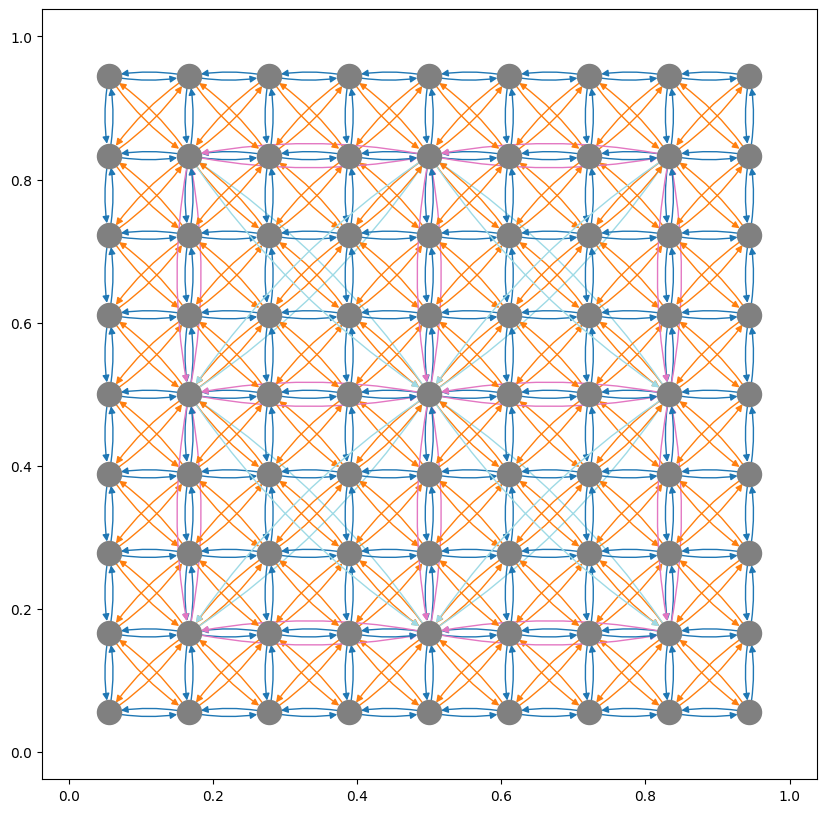

In [52]:
edge_lens = pyg_m2m.len.cpu().numpy()
nx_draw_with_pos_and_length(pyg.utils.to_networkx(pyg_m2m, node_attrs=["pos"], edge_attrs=["len"]))

In [54]:
del(G)

In [90]:
# Divide mesh node pos by max coordinate of grid cell
mesh_pos = [pos/pos_max for pos in  mesh_pos]

# Save mesh positions
# torch.save(mesh_pos, os.path.join(graph_dir_path,
    # "mesh_features.pt")) # mesh pos, in float32

#
# Grid2Mesh
#

# radius within which grid nodes are associated with a mesh node
# (in terms of mesh distance)
DM_SCALE = 0.67

# mesh nodes on lowest level
vm = G_bottom_mesh.nodes
vm_xy = np.array([xy for _, xy in vm.data('pos')])
# distance between mesh nodes
dm = np.sqrt(np.sum((vm.data('pos')[(0,1,0)] - vm.data('pos')[(0,0,0)])**2))

# grid nodes
Ny, Nx = xy.shape[1:]

G_grid = networkx.grid_2d_graph(Ny, Nx)
G_grid.clear_edges()

# vg features (only pos introduced here)
for node in G_grid.nodes:
    # pos is in feature but here explicit for convenience
    G_grid.nodes[node]['pos'] = np.array([xy[0][node],xy[1][node]])
    G_grid.nodes[node]['level'] = -1

# add 1000 to node key to separate grid nodes (1000,i,j) from mesh nodes (i,j)
# and impose sorting order such that vm are the first nodes
G_grid = prepend_node_index(G_grid, 1000)

# build kd tree for grid point pos
# order in vg_list should be same as in vg_xy
vg_list = list(G_grid.nodes)
vg_xy = np.array([[xy[0][node[1:]],xy[1][node[1:]]] for node in vg_list])
kdt_g = scipy.spatial.KDTree(vg_xy)

# now add (all) mesh nodes, include features (pos)
G_mesh = G_tot.copy()
for node in G_mesh.nodes:
    G_mesh.nodes[node]["level"] = 0


# Re-create graph with sorted node indices
# Need to do sorting of nodes this way for indices to map correctly to pyg
G_g2m = networkx.Graph()

G_g2m.add_nodes_from(G_mesh.nodes(data=True))
G_g2m.add_nodes_from(sorted(G_grid.nodes(data=True)))

# turn into directed graph
G_g2m = networkx.DiGraph(G_g2m)

# add edges
for v in vm:
    # find neighbours (index to vg_xy)
    neigh_idxs = kdt_g.query_ball_point(vm[v]['pos'], dm*DM_SCALE)
    for i in neigh_idxs:
        u = vg_list[i]
        # add edge from grid to mesh
        G_g2m.add_edge(u, v)
        d = np.sqrt(np.sum((G_g2m.nodes[u]['pos']-G_g2m.nodes[v]['pos'])**2))
        G_g2m.edges[u,v]['len'] = d
        G_g2m.edges[u,v]['vdiff'] = G_g2m.nodes[u]['pos']-G_g2m.nodes[v]['pos']

pyg_g2m = from_networkx(G_g2m)

if args.plot:
    plot_graph(pyg_g2m, title="Grid-to-mesh")
    plt.show()

In [92]:
len(vg_list

2500

In [95]:
vg_xy

array([[0.        , 0.        ],
       [0.02040816, 0.        ],
       [0.04081633, 0.        ],
       ...,
       [0.95918367, 1.        ],
       [0.97959184, 1.        ],
       [1.        , 1.        ]])

In [96]:
np.array([G_grid.nodes[node]["pos"] for node in G_grid.nodes])

array([[0.        , 0.        ],
       [0.02040816, 0.        ],
       [0.04081633, 0.        ],
       ...,
       [0.95918367, 1.        ],
       [0.97959184, 1.        ],
       [1.        , 1.        ]])

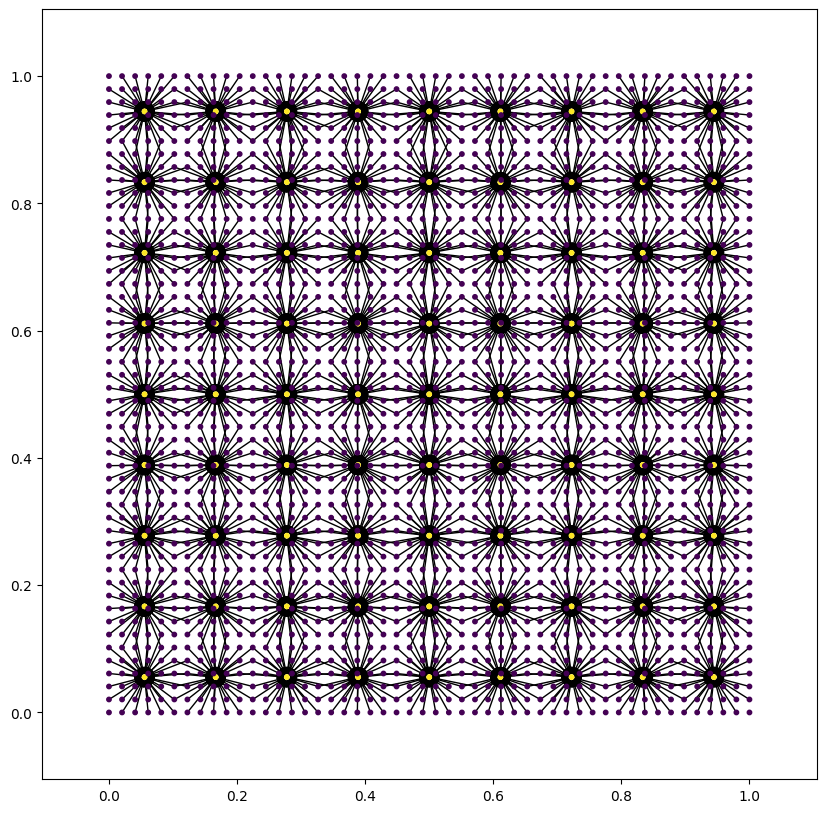

In [91]:
node_color = [G_g2m.nodes[node]["level"] for node in G_g2m.nodes]
nx_draw_with_pos(G_g2m, node_size=10, with_labels=False, node_color=node_color)

In [72]:


#
# Mesh2Grid
#

# start out from Grid2Mesh and then replace edges
G_m2g = G_g2m.copy()
G_m2g.clear_edges()

# build kd tree for mesh point pos
# order in vm should be same as in vm_xy
vm_list = list(vm)
kdt_m = scipy.spatial.KDTree(vm_xy)

# add edges from mesh to grid
for v in vg_list:
    # find 4 nearest neighbours (index to vm_xy)
    neigh_idxs = kdt_m.query(G_m2g.nodes[v]['pos'], 4)[1]
    for i in neigh_idxs:
        u = vm_list[i]
        # add edge from mesh to grid
        G_m2g.add_edge(u, v)
        d = np.sqrt(np.sum((G_m2g.nodes[u]['pos']-G_m2g.nodes[v]['pos'])**2))
        G_m2g.edges[u,v]['len'] = d
        G_m2g.edges[u,v]['vdiff'] = G_m2g.nodes[u]['pos']-G_m2g.nodes[v]['pos']

# relabel nodes to integers (sorted)
G_m2g_int = networkx.convert_node_labels_to_integers(G_m2g, first_label=0,
        ordering='sorted')
pyg_m2g = from_networkx(G_m2g_int)

# Save g2m and m2g everything
# g2m
# save_edges(pyg_g2m, "g2m", graph_dir_path)
# # m2g
# save_edges(pyg_m2g, "m2g", graph_dir_path)

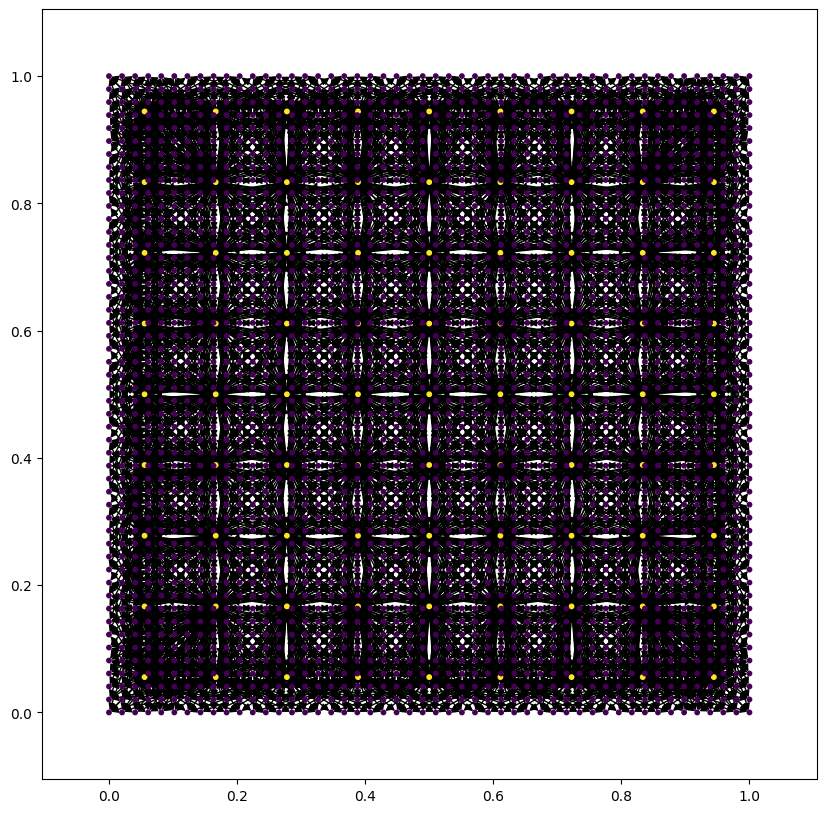

In [73]:
node_color = [G_m2g.nodes[node]["level"] for node in G_m2g.nodes]
nx_draw_with_pos(G_m2g, node_size=10, with_labels=False, node_color=node_color)